## Neural discrete representation learning 


##### The goal of this project is to implement the paper Neural Discrete Representation Learning to understand how we can represent our latent space in a discrete manner.

# Project Overview

## 1. Training a Sample VAE  

In this project, we first train a Variational Autoencoder (VAE) on the concatenation of two datasets: MNIST and fashion_mnist. The goal is to demonstrate that a VAE is incapable of sampling meaningful results consistently when trained on two separate datasets.

## 2. Implementing a VQ-VAE  

To address this issue, we implement a VQ-VAE (Vector Quantized VAE), which represents the latent space in a discrete manner. To evaluate its reconstruction quality, we train this model on CIFAR-10 rather than MNIST to obtain more meaningful results.

## 3. Training a VAE with the Same Structure as VQ-VAE  

We also train a VAE with the same structure as the VQ-VAE for comparison.

## 4. Training a PixelCNN on the Codebook  

Finally, we train a PixelCNN on the codebook to begin learning how to sample using the VQ-VAE.


In [ ]:
#Importation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from torchvision.utils import make_grid


##  Variational Autoencoder (VAE) 


### <span style="color:red"> Looking into the dataset</span>


#### First we will implement a Variational Autoencoder (VAE) that is trained on a concatenation of two datasets: MNIST (handwritten digits) and Fashion-MNIST (clothing items). The model will learn a latent representation that captures the distribution of both datasets, to see the limitation when we represent to different dataset with a continuous latent space, in the case of our VAE a gaussien distribution N(0 , I)

In [9]:


####   loading the two dataset ####
transform = transforms.ToTensor() ### change the image to a tensor
mnist = datasets.MNIST(root="./data_0", train=True, download=True, transform=transform)
fashion_mnist = datasets.FashionMNIST(root="./data_0", train=True, download=True, transform=transform)


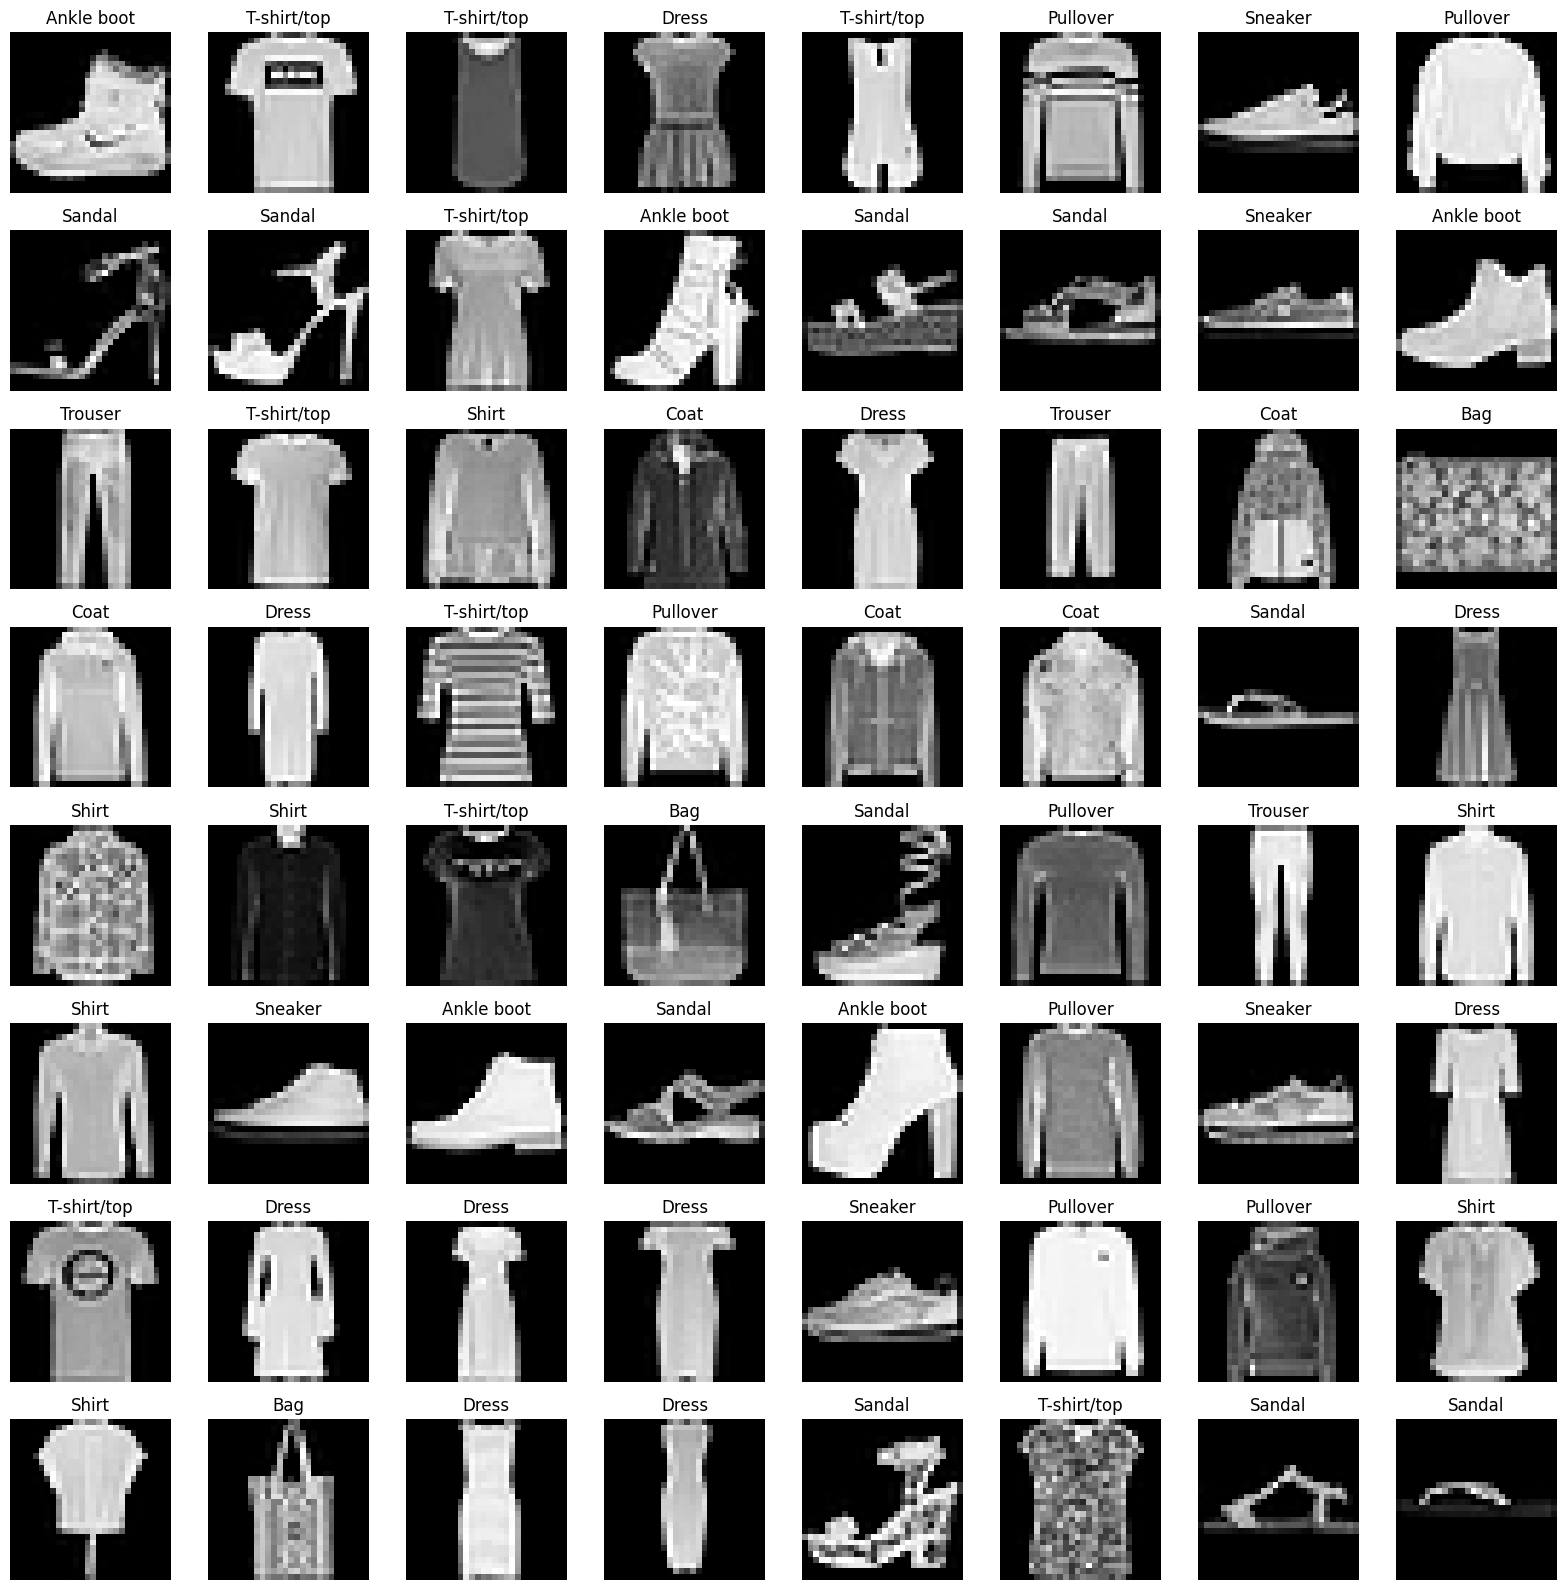

In [ ]:
fig, axes = plt.subplots(8 , 8 , figsize = (16 , 16))
for i in range(64) :
    img , label = fashion_mnist[i]
    img = img.squeeze().numpy()  

    row, col = divmod(i, 8)
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(fashion_mnist.classes[label])  
    axes[row, col].axis("off")  

plt.tight_layout()
plt.show()


In [41]:
#### lets see the distribution of lables 

dict_labels = {}
lenght = len(fashion_mnist)
for i in range(lenght) :
    img , label = fashion_mnist[i]
    if label in dict_labels.keys() : 
        dict_labels[label] += 1
    else : 
        dict_labels[label] = 1    

In [42]:
for label in dict_labels.keys() : 
    print(f" the number of {fashion_mnist.classes[label]} in the data set  is {dict_labels[label]}")

 the number of Ankle boot in the data set  is 6000
 the number of T-shirt/top in the data set  is 6000
 the number of Dress in the data set  is 6000
 the number of Pullover in the data set  is 6000
 the number of Sneaker in the data set  is 6000
 the number of Sandal in the data set  is 6000
 the number of Trouser in the data set  is 6000
 the number of Shirt in the data set  is 6000
 the number of Coat in the data set  is 6000
 the number of Bag in the data set  is 6000


#### The Fashion-MNIST dataset contains 10 classes: 'Ankle boot', 'T-shirt/top', 'Dress', 'Pullover', 'Sneaker', 'Sandal', 'Trouser', 'Shirt', 'Coat', and 'Bag', each with 6,000 samples.

### <span style="color:red">Concatenation of the two datasets</span>


In [43]:


img1 , _ = fashion_mnist[0]
img2, _  = mnist[0]

#### lets check if the two dataset has the same dimensions ####
print(img1.shape ,  img2.shape)


### check the type ####
print(type(img1) , type(img2))

### checks the labels ###

print(mnist.classes , fashion_mnist.classes)

### check the format of labels ###

print(mnist.targets , fashion_mnist.targets)

torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
<class 'torch.Tensor'> <class 'torch.Tensor'>
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
tensor([5, 0, 4,  ..., 5, 6, 8]) tensor([9, 0, 0,  ..., 3, 0, 5])


In [44]:
### there is not much transformation that we should do to concatenate the datasets correctly we need  just to normalize using the same transformation and to translate the target in fashion mnist  #####


mnist_data = mnist.data.float() / 255.0
fashion_data = fashion_mnist.data.float() / 255.0


concat_data = torch.cat((mnist_data, fashion_data), dim=0).unsqueeze(1) 
concat_labels = torch.cat((mnist.targets, fashion_mnist.targets + 10), dim=0) 


### create the combined data set ####

dataset = TensorDataset(concat_data, concat_labels)


In [45]:
img , _  = dataset[0]
print(img.shape)

torch.Size([1, 28, 28])


### <span style="color:red">Theory VAE </span>


# Variational Autoencoder (VAE)

## 1. Principle of VAE


The VAE consists of two main components:
- **Encoder $q_\phi(z|x)$:** Maps input data $x$ to a distribution over latent variables $z$. 
- **Decoder $p_\theta(x|z)$:** Reconstructs the data $x$ from a sample $z$ drawn from the latent distribution. 

The goal of the VAE is to model the true data distribution $p(x)$ using a lower-dimensional representation $z$.



## 2. VAE Loss Function (ELBO)

To train the VAE, we maximize a lower bound on the data likelihood, known as the **Evidence Lower Bound (ELBO)**. This bound captures the quality of reconstruction and regularizes the latent space. The ELBO is defined as:

$$
\mathcal{L}(\phi, \theta) = \mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)] - D_{KL}(q_\phi(z|x) \,||\, p(z))
$$

- **Reconstruction Term:** $\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)]$ ensures the decoder accurately reconstructs the input data $x$ from the latent representation $z$.
- **Regularization Term (KL Divergence):** $D_{KL}(q_\phi(z|x) \,||\, p(z))$ forces the learned latent distribution $q_\phi(z|x)$ to be close to a prior distribution $p(z)$, typically a standard Gaussian $\mathcal{N}(0, I)$.





## 3. Reparameterization Trick

A challenge in training the VAE is that sampling from the latent distribution $q_\phi(z|x)$ is a non-differentiable operation, which complicates optimization using gradient-based methods. To address this, the **reparameterization trick** is used:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Here, instead of sampling $z$ directly from $q_\phi(z|x)$, a noise variable $\epsilon$ is sampled from a standard normal distribution $\mathcal{N}(0, I)$. The latent variable $z$ is then computed as a deterministic function of the input $x$ and the noise $\epsilon$, allowing gradients to be propagated through the sampling process.



### VAE class

In [46]:
class VAE(nn.Module) : 
    def __init__(self , latent_dim = 20) : 
        super(VAE , self).__init__()
        self.latent_dim = latent_dim 

        ## Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4*4*128, 128),  
            nn.ReLU()
        )


        ## Add tha layer to compute the mean and the ecart-type of the latent space 

        
        self.mu = nn.Linear(128, latent_dim)
        self.var = nn.Linear(128, latent_dim)
        
        ## Decoder
        self.decoder_cor = nn.Linear(latent_dim, 7*7*128)  
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),  
            nn.Sigmoid()
        )

    def reparemetrise_trick(self , mu , var) : 
            std = torch.exp(0.5 * var)
            eps = torch.randn_like(std)
            return mu + eps*std
        
        
    def forward(self , x) : 
            x_encoded = self.encoder(x)
            
            mu_x , var_x = self.mu(x_encoded) , self.var(x_encoded)
            z_latent = self.reparemetrise_trick(mu_x , var_x)
            z_latent_cor = self.decoder_cor(z_latent).view(-1, 128, 7, 7)
            x_recontructed = self.decoder(z_latent_cor)
            return x_recontructed , mu_x , var_x
    


## Loss function of our model 

In [47]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

## Train our VAE model

In [49]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = torch.device("cpu")
vae = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(vae.parameters() , lr = 1e-4)



In [50]:
epochs = 40
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x, _ = batch
        x = x.to(device)
        
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss per Image: {total_loss / len(dataloader.dataset):.4f}")    

Epoch [1/40], Loss per Image: 265.6200
Epoch [2/40], Loss per Image: 205.3111
Epoch [3/40], Loss per Image: 194.8175
Epoch [4/40], Loss per Image: 190.0761
Epoch [5/40], Loss per Image: 187.1435
Epoch [6/40], Loss per Image: 185.1937
Epoch [7/40], Loss per Image: 183.8517
Epoch [8/40], Loss per Image: 182.8277
Epoch [9/40], Loss per Image: 181.9280
Epoch [10/40], Loss per Image: 181.2575
Epoch [11/40], Loss per Image: 180.6399
Epoch [12/40], Loss per Image: 180.1103
Epoch [13/40], Loss per Image: 179.6755
Epoch [14/40], Loss per Image: 179.2325
Epoch [15/40], Loss per Image: 178.8631
Epoch [16/40], Loss per Image: 178.5067
Epoch [17/40], Loss per Image: 178.1625
Epoch [18/40], Loss per Image: 177.8839
Epoch [19/40], Loss per Image: 177.6257
Epoch [20/40], Loss per Image: 177.3441
Epoch [21/40], Loss per Image: 177.0911
Epoch [22/40], Loss per Image: 176.8925
Epoch [23/40], Loss per Image: 176.6733
Epoch [24/40], Loss per Image: 176.4654
Epoch [25/40], Loss per Image: 176.2818
Epoch [26

In [51]:
torch.save(vae, "vae_model.pth")

### Samples

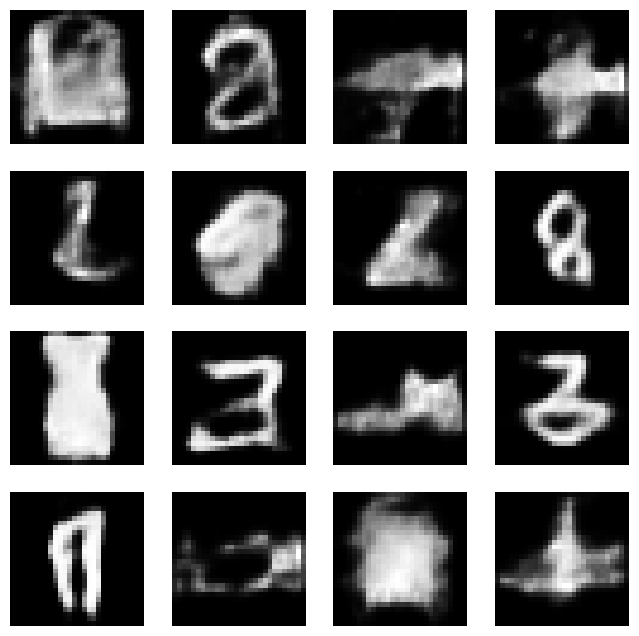

In [52]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # Random latent vectors
    samples = vae.decoder_cor(z).view(-1, 128, 7, 7)  # Correct reshaping for decoder input
    samples = vae.decoder(samples).cpu().numpy()

# Plot generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()


### As we can see the continuous representation of latent space give us  some strange samples, because the continuous representation isn't adequat in this cases, so the idea to look for a methode that represent the latent space in a discret manner, we could see this also in the second part when we are going to compare the performance of a VQ-VAE and the VAE in term of reconstruction

## III- VQ-VAE

#### In this part we are going to implement the VQ-VAE as it described in the papaer

### <span style="color:red">Theory VQ-VAE </span>
 

# Vector Quantized Variational Autoencoder (VQ-VAE)

## 1. Principle of VQ-VAE

The **Vector Quantized Variational Autoencoder (VQ-VAE)** is a variant of the standard VAE that replaces continuous latent variables with **discrete** latent representations. 

Instead of learning a continuous latent space, VQ-VAE uses a **3D tensor of discrete latent variables** $z \in \mathbb{R}^{H \times W \times K}$, where:
- $H \times W$ represents the spatial dimensions of the latent space.
- $K$ is the number of possible discrete values for each latent variable.

The encoder maps an input $x$ to a continuous latent representation $z_e(x)$, which is then **quantized** by matching it to the closest entry in a learned **codebook** of embedding vectors $\{e_k\}_{k=1}^{K}$, where each $e_k \in \mathbb{R}^D$. The quantization process is defined as:

$$
q(z_{ij} = k | x) =
\begin{cases}
1, & \text{if } k = \arg\min_{k'} ||z_e(x)_{i,j,:} - e_{k'}||^2 \\
0, & \text{otherwise}
\end{cases}
$$

This means that each latent variable $z_{ij}$ is assigned the index of the nearest codebook vector, replacing the continuous latent representation with a **discrete** one.



## 2. VQ-VAE Loss Function

The reconstruction process follows a standard VAE-like structure, where the discrete latent representation is decoded back into the input space. During decoding, the selected **discrete code indices** are replaced by their corresponding **real-valued** codebook vectors:

$$
(z_q)_{ij} = e_k \quad \text{where } z_{ij} = k
$$

The decoder then reconstructs the input as $p(x | z_q)$. However, unlike traditional VAEs, VQ-VAE does not optimize a KL divergence term, since the latent variables are discrete, and in this case we have a constant KL.

The **loss function** consists of three main terms:
1. **Reconstruction Loss:** Measures how well the decoded output matches the original input:
   $$
   -\log p(x | z_q(x))
   $$
2. **Codebook Loss:** Encourages the codebook embeddings to match the encoder output:
   $$
   ||sg(z_e(x)) - e||^2_2
   $$
   Here, $sg$ represents the **stop-gradient operator**, ensuring that $z_e(x)$ is treated as a fixed target, preventing gradients from flowing into it.
3. **Commitment Loss:** Ensures that the encoder output does not fluctuate too much between different codebook entries, stabilizing the learning process:
   $$
   ||z_e(x) - sg(e)||^2_2
   $$

   The commitment loss encourages the encoder output to stay close to the selected codebook vector, preventing unnecessary oscillations.


## 3. Straight-Through Estimator and Training

A key challenge in training VQ-VAE is handling the **non-differentiability** of the quantization process. To overcome this, the **straight-through estimator** is used:

- Instead of computing gradients through the discrete assignment step, gradients are passed from the decoder input $z_q(x)$ to the encoder output $z_e(x)$.
- This allows the encoder to be updated despite the non-differentiability of the quantization step.



The final loss function for VQ-VAE is:

$$
L = - \log p(x | z_q(x)) + ||sg(z_e(x)) - e||^2_2 + ||z_e(x) - sg(e)||^2_2
$$

where:
- The **decoder** optimizes only the **reconstruction term**.
- The **encoder** optimizes the **reconstruction term** and the **commitment loss**.
- The **codebook embeddings** are updated using the **codebook loss**.



![Mon Image](vq_img.png)


In [ ]:
train_data = datasets.CIFAR10(root = "data"  , train=True ,download=True ,transform=transforms.Compose([
    transform , 
    transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
]))

test_data = datasets.CIFAR10(root = "data" , train=False , download=True , transform=transforms .Compose([
    transform , 
    transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
]))

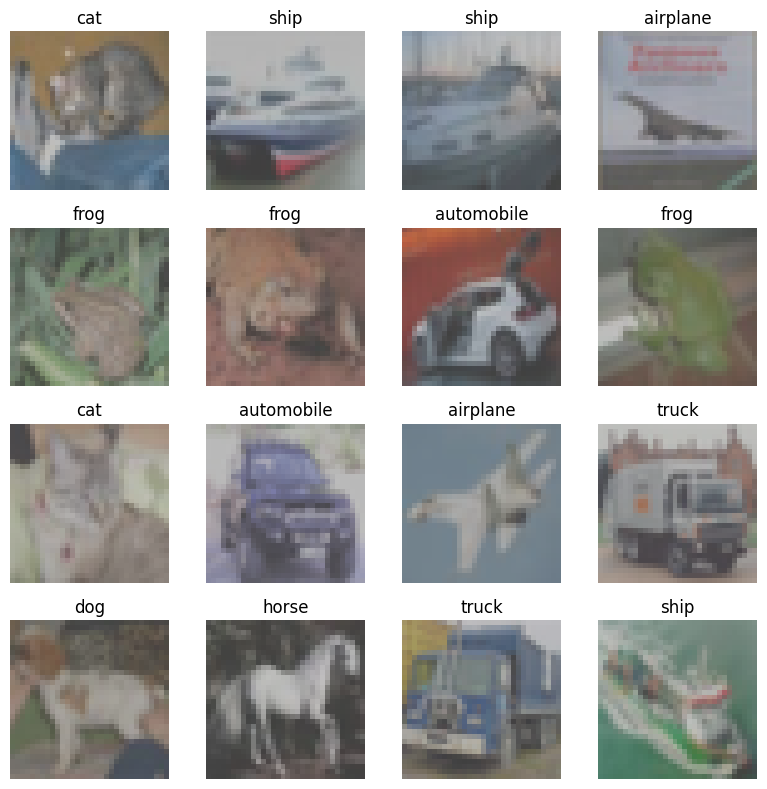

In [ ]:
cifar10_classes = test_data.classes

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(16):
    img, label = test_data[i]  
    img = img.permute(1, 2, 0).numpy()  
    
    row, col = divmod(i, 4)  
    axes[row, col].imshow(np.clip(img * 0.5 + 0.5, 0, 1))  
    axes[row, col].set_title(cifar10_classes[label])  
    axes[row, col].axis("off")  

plt.tight_layout()
plt.show()

In [ ]:
###This cell contains the blocks of VQ-VAE.
class VQEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_loss):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0/num_embeddings, 1.0/num_embeddings)
        self.commitment_loss = commitment_loss

    def forward(self, x):
        
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape
        flat_x = x.view(-1, self.embedding_dim)
        
        # Compute Euclidean distance between x and embedding weights
        distances = (torch.sum(flat_x ** 2, dim=1, keepdim=True) +
                     torch.sum(self.embedding.weight ** 2, dim=1) -
                     2 * torch.matmul(flat_x, self.embedding.weight.t()))
        
        # Find nearest embedding for each input vector
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize our vector
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        
        # Compute losses
        e_loss = F.mse_loss(quantized.detach(), x)
        q_loss = F.mse_loss(quantized, x.detach())
        loss = q_loss + self.commitment_loss * e_loss
        
        # Straight-through estimator
        quantized = x + (quantized - x).detach()
        
       
  
        
        
   
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encodings


class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_res_layers, res_hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels // 2, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        
       
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden_channels, res_hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(res_hidden_channels, hidden_channels, kernel_size=1, stride=1, bias=False)
            )
            for _ in range(num_res_layers)
        ])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        for block in self.residual_blocks:
            x = x + block(x)
        return F.relu(x)


class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_channels, num_res_layers, res_hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(embedding_dim, hidden_channels, kernel_size=3, stride=1, padding=1)
        
       
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden_channels, res_hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(res_hidden_channels, hidden_channels, kernel_size=1, stride=1, bias=False)
            )
            for _ in range(num_res_layers)
        ])
        
        self.conv_trans1 = nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(hidden_channels // 2, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        for block in self.residual_blocks:
            x = x + block(x)
        x = F.relu(x)
        x = F.relu(self.conv_trans1(x))
        return self.conv_trans2(x)


class VQVAE(nn.Module):
    def __init__(self, hidden_channels, num_res_layers, res_hidden_channels,
                 num_embeddings, embedding_dim, commitment_loss):
        super().__init__()
        self.encoder = Encoder(3, hidden_channels, num_res_layers, res_hidden_channels)
        self.pre_vq_conv = nn.Conv2d(hidden_channels, embedding_dim, kernel_size=1, stride=1)
        self.vq_embed = VQEmbedding(num_embeddings, embedding_dim, commitment_loss)
        self.decoder = Decoder(embedding_dim, hidden_channels, num_res_layers, res_hidden_channels)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        vq_loss, quantized, _ = self.vq_embed(z)
        x_recon = self.decoder(quantized)
        return vq_loss, x_recon




In [ ]:
##### training the  VQ-VAE

batch_size = 256
num_updates = 30000
hidden_channels = 128
res_hidden_channels = 32
num_res_layers = 2

embedding_dim = 64
num_embeddings = 512
commitment_loss = 0.25
learning_rate = 1e-3


training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True)
data_variance = np.var(train_data.data / 255.0)


model = VQVAE(hidden_channels, num_res_layers, res_hidden_channels,
              num_embeddings, embedding_dim, commitment_loss).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)


model.train()
recon_errors = []

for update in range(num_updates):
    
    data, _ = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, recon = model(data)
    recon_error = F.mse_loss(recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()
    optimizer.step()

    recon_errors.append(recon_error.item())

    if (update + 1) % 10 == 0:
        print(f"{update+1} iterations")
        print(f"recon_error: {np.mean(recon_errors[-10:]):.3f}\n")



10 iterations
recon_error: 1.053

20 iterations
recon_error: 0.880

30 iterations
recon_error: 0.795

40 iterations
recon_error: 0.689

50 iterations
recon_error: 0.613

60 iterations
recon_error: 0.651

70 iterations
recon_error: 0.909

80 iterations
recon_error: 1.076

90 iterations
recon_error: 0.983

100 iterations
recon_error: 0.998

110 iterations
recon_error: 0.929

120 iterations
recon_error: 0.723

130 iterations
recon_error: 0.609

140 iterations
recon_error: 0.529

150 iterations
recon_error: 0.488

160 iterations
recon_error: 0.462

170 iterations
recon_error: 0.453

180 iterations
recon_error: 0.439

190 iterations
recon_error: 0.428

200 iterations
recon_error: 0.494

210 iterations
recon_error: 0.490

220 iterations
recon_error: 0.471

230 iterations
recon_error: 0.487

240 iterations
recon_error: 0.468

250 iterations
recon_error: 0.410

260 iterations
recon_error: 0.407

270 iterations
recon_error: 0.451

280 iterations
recon_error: 0.412

290 iterations
recon_error: 0

In [ ]:
#model = torch.load("vq_vae_model.pth" , weights_only=False)

In [ ]:
recon_error_smooth = savgol_filter(recon_errors, 201, 7)


In [ ]:
torch.save(recon_error_smooth , 'err_smoth_02.pt')

In [ ]:
torch.save(recon_errors , 'err_vq_02.pt')

Text(0.5, 0, 'iteration')

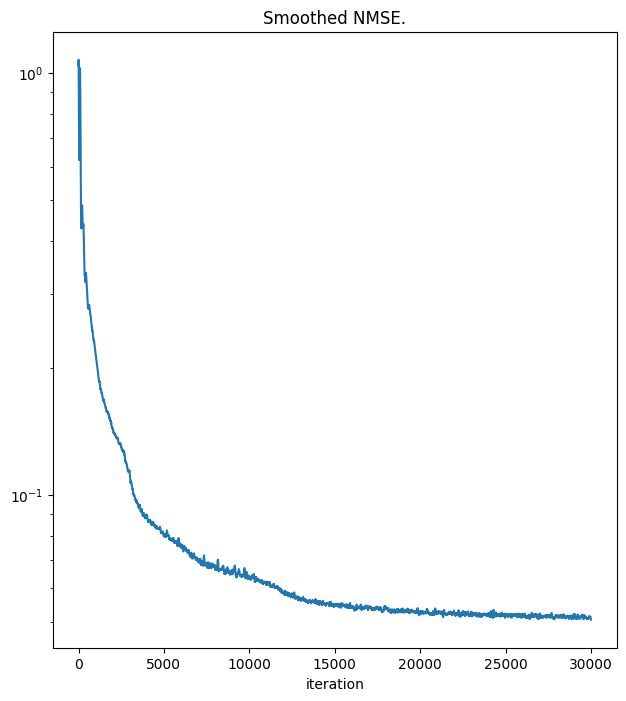

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

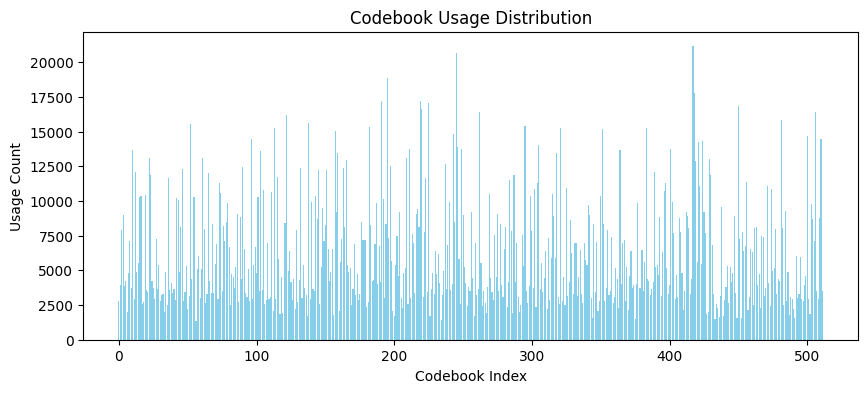

In [ ]:
usage_counts = torch.zeros(model.vq_embed.embedding.num_embeddings)

model.eval()  
with torch.no_grad():
    for data, _ in training_loader:
        data = data.to(device)
        
        z = model.encoder(data)
        z = model.pre_vq_conv(z)
        
        _, _, encodings = model.vq_embed(z)
        
        usage_counts += encodings.sum(dim=0).cpu()

model.train()  

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(usage_counts)), usage_counts.numpy(), color='skyblue')
plt.xlabel("Codebook Index")
plt.ylabel("Usage Count")
plt.title("Codebook Usage Distribution")
plt.show()

### Approximately all the vectors are used in the codebook, which proves that we have a strong discrete distribution over the latent space.

#### Dans cette partie nous allonns entrainer un VAE dans les donnée cifar10 pour comparer la qualité de contruction entre le VQ et le VAE 

In [ ]:


class EncoderVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_res_layers, res_hidden_channels, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels // 2, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden_channels, res_hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(res_hidden_channels, hidden_channels, kernel_size=1, stride=1, bias=False)
            )
            for _ in range(num_res_layers)
        ])
        
        # compute the mean and standard deviation
        self.fc_mu = nn.Conv2d(hidden_channels, latent_dim, kernel_size=1, stride=1)
        self.fc_logvar = nn.Conv2d(hidden_channels, latent_dim, kernel_size=1, stride=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        for block in self.residual_blocks:
            x = x + block(x)
        x = F.relu(x)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class DecoderVAE(nn.Module):
    def __init__(self, latent_dim, hidden_channels, num_res_layers, res_hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(latent_dim, hidden_channels, kernel_size=3, stride=1, padding=1)
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden_channels, res_hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ReLU(inplace=True),
                nn.Conv2d(res_hidden_channels, hidden_channels, kernel_size=1, stride=1, bias=False)
            )
            for _ in range(num_res_layers)
        ])
        
        self.conv_trans1 = nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, kernel_size=4, stride=2, padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(hidden_channels // 2, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        for block in self.residual_blocks:
            x = x + block(x)
        x = F.relu(x)
        x = F.relu(self.conv_trans1(x))
        return self.conv_trans2(x)


class VAE(nn.Module):
    def __init__(self, hidden_channels, num_res_layers, res_hidden_channels, latent_dim):
        super().__init__()
        self.encoder = EncoderVAE(3, hidden_channels, num_res_layers, res_hidden_channels, latent_dim)
        self.decoder = DecoderVAE(latent_dim, hidden_channels, num_res_layers, res_hidden_channels)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

#### hyperparametres : only the number if training updates are changed as the VAE converge faster than the VQ-VAE
num_updates = 15000
latent_dim = 64  


device = torch.device("cpu")
model_vae = VAE(hidden_channels, num_res_layers, res_hidden_channels, latent_dim).to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=learning_rate)

model_vae.train()
recon_errors = []

for update in range(num_updates):
  
    data, _ = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    recon, mu, logvar = model_vae(data)
   
    recon_error = F.mse_loss(recon, data) / data_variance
    

    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = recon_error + kl_loss
    loss.backward()
    optimizer.step()

    recon_errors.append(recon_error.item())

    if (update + 1) % 10 == 0:
        print(f"{update+1} iterations")
        print(f"recon_error: {np.mean(recon_errors[-10:]):.3f}\n")


10 iterations
recon_error: 1.061

20 iterations
recon_error: 0.797

30 iterations
recon_error: 0.617

40 iterations
recon_error: 0.455

50 iterations
recon_error: 0.372

60 iterations
recon_error: 0.336

70 iterations
recon_error: 0.314

80 iterations
recon_error: 0.300

90 iterations
recon_error: 0.288

100 iterations
recon_error: 0.287

110 iterations
recon_error: 0.279

120 iterations
recon_error: 0.270

130 iterations
recon_error: 0.274

140 iterations
recon_error: 0.263

150 iterations
recon_error: 0.260

160 iterations
recon_error: 0.258

170 iterations
recon_error: 0.250

180 iterations
recon_error: 0.244

190 iterations
recon_error: 0.230

200 iterations
recon_error: 0.241

210 iterations
recon_error: 0.215

220 iterations
recon_error: 0.205

230 iterations
recon_error: 0.200

240 iterations
recon_error: 0.193

250 iterations
recon_error: 0.186

260 iterations
recon_error: 0.182

270 iterations
recon_error: 0.175

280 iterations
recon_error: 0.180

290 iterations
recon_error: 0

In [ ]:
torch.save(model_vae , 'vae_cifar_10_02.pth')
print("saved")

saved


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

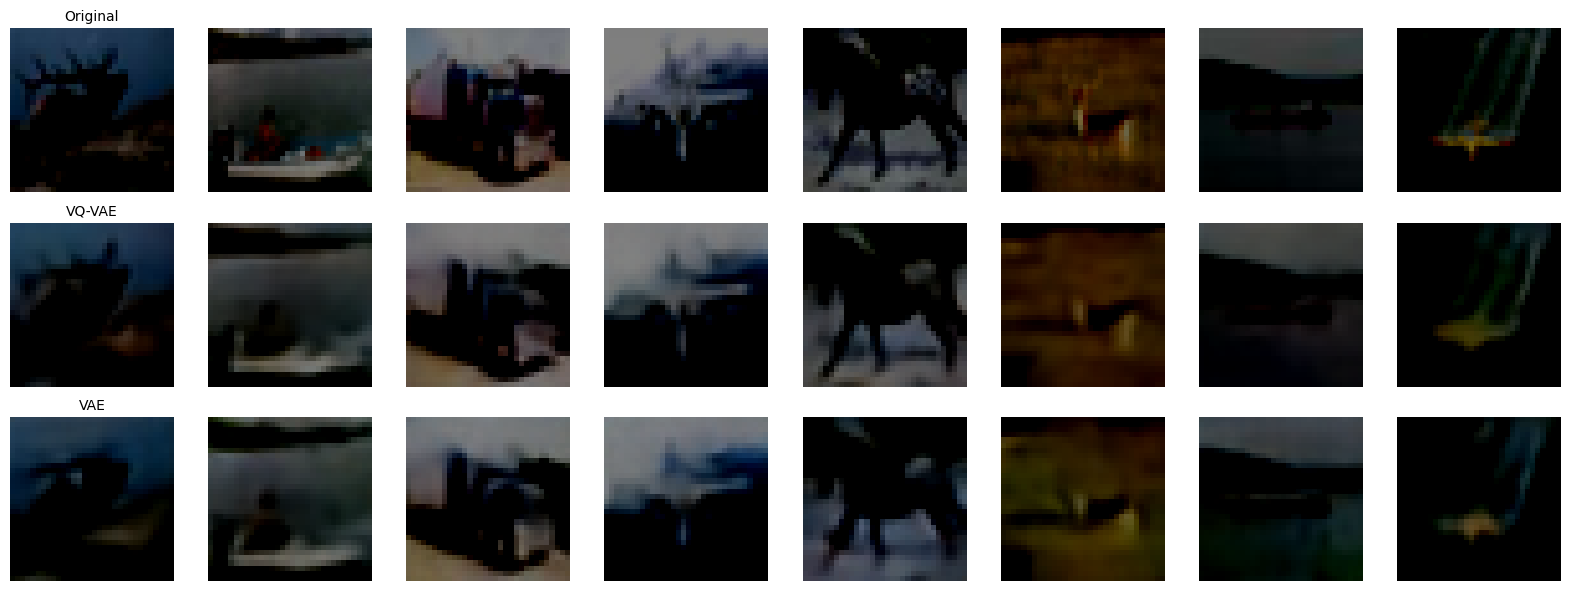

In [ ]:


model.eval()
model_vae.eval()


(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

with torch.no_grad():
    

    vq_loss, vq_reconstructions = model(valid_originals)
    
  
    
    vae_reconstructions, mu, logvar = model_vae(valid_originals)


### the function compare reconstruction show the original and reconstructed images from the VQ-VAE so we could see the quality of each model

def compare_reconstructions(original, recon_vq, recon_vae, num_images=8):
    
    
    original = original.detach().cpu()
    recon_vq = recon_vq.detach().cpu()
    recon_vae = recon_vae.detach().cpu()

   
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 6))

    for i in range(num_images):
       
        img_orig = original[i].permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_orig, interpolation='nearest')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original", fontsize=10)
        
        
        img_vq = recon_vq[i].permute(1, 2, 0).numpy()
        axes[1, i].imshow(img_vq, interpolation='nearest')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("VQ-VAE", fontsize=10)
        
        
        img_vae = recon_vae[i].permute(1, 2, 0).numpy()
        axes[2, i].imshow(img_vae, interpolation='nearest')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title("VAE", fontsize=10)

    plt.tight_layout()
    plt.show()


compare_reconstructions(valid_originals, vq_reconstructions, vae_reconstructions, num_images=8)


### As we can see, the results given by the two models are very similar to the human eye, which proves that the models produce similar results, as stated by the authors in their paper.

### In the section below, we are going to compute *SSIM* as a metric to assess the quality of reconstruction.



**SSIM** evaluates the structural similarity between two images. 

### **Formula**
SSIM between two images $X$ and $Y$ is given by:

$$
\text{SSIM}(X, Y) = \frac{(2\mu_X\mu_Y + C_1)(2\sigma_{XY} + C_2)}{(\mu_X^2 + \mu_Y^2 + C_1)(\sigma_X^2 + \sigma_Y^2 + C_2)}
$$

where:
- $\mu_X, \mu_Y$ → Mean intensities of images $X$ and $Y$,
- $\sigma_X^2, \sigma_Y^2$ → Variances of $X$ and $Y$,
- $\sigma_{XY}$ → Covariance between $X$ and $Y$,
- $C_1, C_2$ → Small constants for stability.

### **Interpretation**
- **SSIM = 1** → The images are identical.
- **SSIM = 0** → The images are completely different.
- Higher SSIM values indicate **better perceptual quality**.

In [ ]:

from math import log10
from skimage.metrics import structural_similarity as compare_ssim  


def compute_mse(original, reconstruction):
    
    mse_val = F.mse_loss(reconstruction, original, reduction='mean').item()
    return mse_val

def compute_psnr(mse, max_pixel=1.0):
    
    if mse == 0:
        return float('inf')
    psnr_val = 20 * log10(max_pixel) - 10 * log10(mse)
    return psnr_val

def compute_ssim_batch(original, reconstruction):
    
    original_np = original.detach().cpu().numpy()
    reconstruction_np = reconstruction.detach().cpu().numpy()
    ssim_scores = []
    batch_size = original_np.shape[0]
    for i in range(batch_size):
        
        orig_img = np.transpose(original_np[i], (1, 2, 0))
        recon_img = np.transpose(reconstruction_np[i], (1, 2, 0))
        
        ssim_val = compare_ssim(orig_img, recon_img, multichannel=True, data_range=orig_img.max()-orig_img.min())
        ssim_scores.append(ssim_val)
    return np.mean(ssim_scores)


model.eval()
model_vae.eval()


(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

with torch.no_grad():
    
    vq_loss, vq_reconstructions = model(valid_originals)
    
    vae_reconstructions, mu, logvar = model_vae(valid_originals)


mse_vq   = compute_mse(valid_originals, vq_reconstructions)
psnr_vq  = compute_psnr(mse_vq)
ssim_vq  = compute_ssim_batch(valid_originals, vq_reconstructions)


mse_vae  = compute_mse(valid_originals, vae_reconstructions)
psnr_vae = compute_psnr(mse_vae)
ssim_vae = compute_ssim_batch(valid_originals, vae_reconstructions)

print("Comparaison OF reconstructions Quality :\n")
print("VQ-VAE : MSE = {:.4f}, PSNR = {:.2f} dB, SSIM = {:.4f}".format(mse_vq, psnr_vq, ssim_vq))
print("VAE    : MSE = {:.4f}, PSNR = {:.2f} dB, SSIM = {:.4f}".format(mse_vae, psnr_vae, ssim_vae))


Comparaison des reconstructions sur le batch de validation :

VQ-VAE : MSE = 0.0038, PSNR = 24.25 dB, SSIM = 0.7933
VAE    : MSE = 0.0047, PSNR = 23.24 dB, SSIM = 0.7247


C:\Users\oussa\AppData\Local\Temp\ipykernel_17196\2041504170.py:39: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = compare_ssim(orig_img, recon_img, multichannel=True, data_range=orig_img.max()-orig_img.min())


### In comparison between the two models, we observe that VQ-VAE provides  better results compared to VAE on this discrete dataset, which confirms the claims of the author.

### In this part we are going to build a Pixelcnn to train it on the codebook so we could be able to sample from the VQ-VAE 

Starting training of the PixelCNN prior...
Epoch 1: Loss = 6.1877
Epoch 2: Loss = 6.0103
Epoch 3: Loss = 5.8454
Epoch 4: Loss = 5.7492
Epoch 5: Loss = 5.6834
Epoch 6: Loss = 5.6384
Epoch 7: Loss = 5.6055
Epoch 8: Loss = 5.5795
Epoch 9: Loss = 5.5580
Epoch 10: Loss = 5.5384
Epoch 11: Loss = 5.5218
Epoch 12: Loss = 5.5073
Epoch 13: Loss = 5.4935
Epoch 14: Loss = 5.4827
Epoch 15: Loss = 5.4708
Epoch 16: Loss = 5.4613
Epoch 17: Loss = 5.4513
Epoch 18: Loss = 5.4417
Epoch 19: Loss = 5.4316
Epoch 20: Loss = 5.4227
Epoch 21: Loss = 5.4144
Epoch 22: Loss = 5.4065
Epoch 23: Loss = 5.3970
Epoch 24: Loss = 5.3899
Epoch 25: Loss = 5.3816
Epoch 26: Loss = 5.3734
Epoch 27: Loss = 5.3659
Epoch 28: Loss = 5.3590
Epoch 29: Loss = 5.3496
Epoch 30: Loss = 5.3413
Epoch 31: Loss = 5.3332
Epoch 32: Loss = 5.3253
Epoch 33: Loss = 5.3165
Epoch 34: Loss = 5.3070
Epoch 35: Loss = 5.2985
Epoch 36: Loss = 5.2880
Epoch 37: Loss = 5.2795
Epoch 38: Loss = 5.2692
Epoch 39: Loss = 5.2603
Epoch 40: Loss = 5.2506
Epoch 

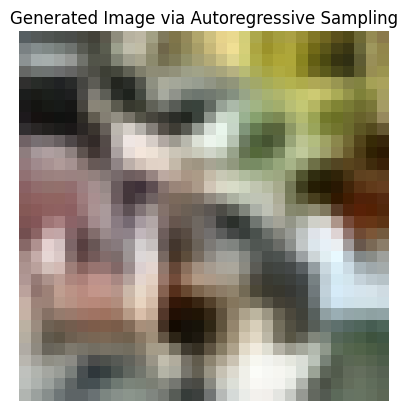

In [ ]:


class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer("mask", torch.ones_like(self.weight))
        kH, kW = self.weight.size()[2], self.weight.size()[3]
        center_h, center_w = kH // 2, kW // 2

        for i in range(kH):
            for j in range(kW):
                if i > center_h or (i == center_h and j > center_w):
                    self.mask[:, :, i, j] = 0
        if mask_type == "A":
            self.mask[:, :, center_h, center_w] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_channels=64, num_layers=7):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.input_conv = MaskedConv2d(
            in_channels=embedding_dim,
            out_channels=hidden_channels,
            kernel_size=7,
            mask_type="A",
            padding=3
        )
        self.layers = nn.ModuleList([
            MaskedConv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                mask_type="B",
                padding=1
            ) for _ in range(num_layers)
        ])
        self.output_conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, num_embeddings, kernel_size=1)
        )

    def forward(self, x):
        
        x = self.embedding(x)  
        x = x.permute(0, 3, 1, 2).contiguous()  
        x = self.input_conv(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output_conv(x)
        return logits


device = torch.device("cpu")


hidden_channels = 128
num_res_layers = 2
res_hidden_channels = 64
num_embeddings = 512
embedding_dim = 64
commitment_loss = 0.25




model.eval()  


data_sample, _ = next(iter(training_loader))
data_sample = data_sample.to(device)
with torch.no_grad():
    z = model.encoder(data_sample)
    z = model.pre_vq_conv(z)
    _, quantized, encodings = model.vq_embed(z)
    B_sample, C_sample, H_lat, W_lat = quantized.shape


prior_model = PixelCNN(num_embeddings, embedding_dim, hidden_channels=64, num_layers=7).to(device)
optimizer_prior = optim.Adam(prior_model.parameters(), lr=1e-3, weight_decay=1e-5)


num_epochs = 100  

print("Starting training of the PixelCNN prior...")
prior_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (data, _) in enumerate(training_loader):
        data = data.to(device)
        optimizer_prior.zero_grad()
        
        
        with torch.no_grad():
            z = model.encoder(data)
            z = model.pre_vq_conv(z)
            _, quantized, encodings = model.vq_embed(z)
        
        B_current = data.size(0)
        latent_codes = torch.argmax(encodings, dim=1).view(B_current, H_lat, W_lat)
        
     
        logits = prior_model(latent_codes)  
        
 
        loss = F.cross_entropy(logits.view(-1, num_embeddings), latent_codes.view(-1))
        loss.backward()
        optimizer_prior.step()
        
        epoch_loss += loss.item()
    print("Epoch {}: Loss = {:.4f}".format(epoch + 1, epoch_loss / len(training_loader)))



def sample_autoregressive(vqvae_model, prior_model, latent_grid_size, temperature=1.0):
    
    device = next(vqvae_model.parameters()).device
    H_lat, W_lat = latent_grid_size
    latent_codes = torch.zeros((1, H_lat, W_lat), dtype=torch.long, device=device)
    
    prior_model.eval()
    vqvae_model.eval()
    with torch.no_grad():

        for i in range(H_lat):
            for j in range(W_lat):
                logits = prior_model(latent_codes)  
                logits_ij = logits[0, :, i, j] / temperature
                probs_ij = F.softmax(logits_ij, dim=0)
                sampled_index = torch.multinomial(probs_ij, num_samples=1)
                latent_codes[0, i, j] = sampled_index.item()
        
        
        quantized = vqvae_model.vq_embed.embedding(latent_codes.view(-1))
        quantized = quantized.view(1, H_lat, W_lat, embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()  
        
        generated_image = vqvae_model.decoder(quantized)
    return generated_image


latent_grid_size = (H_lat, W_lat)  
generated_img = sample_autoregressive(model, prior_model, latent_grid_size, temperature=0.8)

def show(img, title=None):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


show(make_grid(generated_img, normalize=True), title="Generated Image via Autoregressive Sampling")

In [ ]:
torch.save(prior_model, "prior_model_last_02.pth")
print("Model saved successfully!")


Model saved successfully!


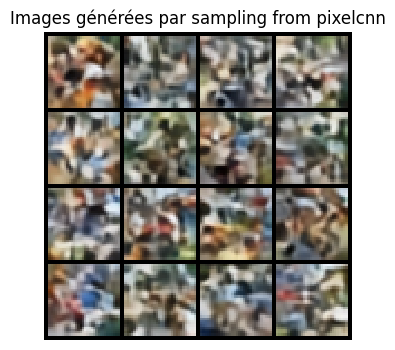

In [ ]:


#### sample image from VQ-VAE using PixelCnn
latent_grid_size = (H_lat, W_lat)  
num_samples = 16  


samples_list = []
for i in range(num_samples):
    generated_img = sample_autoregressive(model, prior_model, latent_grid_size, temperature=0.5)
    samples_list.append(generated_img)


samples_tensor = torch.cat(samples_list, dim=0)

def show(img, title=None):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(4,4))  
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


show(make_grid(samples_tensor, nrow=4, normalize=True), title="Images générées par sampling from pixelcnn")



### As we can see, the images are not very clear, which is due to the fact that we need to train our PixelCNN on the codebook for a longer period. However, we can already observe some structure in the images, which is a positive sign because if we sample from the VAE directly, we would obtain much noisier images than these.

## References 

[1] Neural Discrete Representation Learning [click here to access to the paper](https://www.markdownguide.org/).

[2] Probabilistic machine learning : An advanced topics [click here to access to the book](https://probml.github.io/pml-book/book2.html)

[3] Hugging face : Understanding Vector Quantization in VQ-VAE [click here to access to the article](https://huggingface.co/blog/ariG23498/understand-vq)

[4] medium : Understanding Vector Quantized Variational Autoencoders (VQ-VAE) [click here to access to the article](https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a), [click here to access to the code](https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb)
